In [1]:
#import packages
from autograd import numpy as np
from autograd import grad
import autograd.numpy.random as npr
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

Some formulas

#### Objective: 
$$\nabla_{\theta,\phi} ELBO (\theta, q_{\phi}) = \sum_{n} \mathbb{E}_{q_{\phi}(z_n)} \log p_{\theta}(y_n|z_n) - D_{KL}[q_{\phi}(z_n) || p_{\theta}(z_n) ]$$

Assume $ p_{\theta}(z_n)$ has a normal prior $\mathcal{N}(0,I)$. Let the latent space have J dimensions, i.e. $\mu_n = [\mu_{1_n}, \ldots, \mu_{J_n}]$ and 
$\Sigma_n = \begin{bmatrix} \sigma_{1_n}^2 &\ldots &0 \\
\vdots & \ddots & \vdots\\
0 & \ldots & \sigma_{J_n}^2\\
\end{bmatrix}$

So, $- D_{KL}[q_{\phi}(z_n) || p_{\theta}(z_n) ] = \frac{1}{2} \sum_{j=1}^J (1+log(\sigma_{j_n}^2 )- \mu_{j_n}^2 - \sigma_{j_n}^2 )$

---

Toy example for 2 dimensional data and 1 dimensional latent space

> FYI I might have mixed up variance and standard deviation in diff places so that's fun

In [2]:
# just setting these as examples 
#y_n is one data point, L is the number of samples to estimate the expectation of the likelihood,
# sigma data is the standard deviation of the data
y_n = np.array([0.24, 0.01])
sigma_data = np.array([[0.2, 0.0],[0.0, 0.2]])
latent_dim = 2

In [3]:
# define inference model function
def g_phi(phi1, phi2, y_n):
    '''
    y_n is a vector of shape (,2)
    phi_1, phi_2 are vectors of shape (latent_dim, 2) 
    '''
    mu_n = np.dot(phi1, y_n.T)
    log_std_n = np.dot(phi2, y_n.T) # added abs to make this positive always
    
    return mu_n, log_std_n

In [4]:
# define likelihood model function
def f_theta(theta, z_n, sigma_data = sigma_data):
    '''
    This is the prediction function. 
    
    theta: with shape (latent_dim, y_n_dim)
    z_n: with shape (L, latent_dim)
    '''
    return np.dot(z_n, theta) 

In [5]:
# monte carlo to get expectation of the likelihood
## I added 0.000001 to help the log
def monte_carlo_expectation(theta, mu_n, log_std_n, L, y_n, sigma_data, latent_dim):
    
    # sample L latent variables 
    seed = npr.RandomState(10)
    z_n = seed.randn(int(L),latent_dim) * np.exp(log_std_n) + np.repeat(mu_n.reshape(-1, 1), L, axis = 1).T

    # get predictions using the prediction function, i.e. f_theta
    y_n_pred = f_theta(theta, z_n) # this is an array bc z_n is an array
    y_n_full = np.repeat(y_n.reshape(-1,1), y_n_pred.shape[0], axis = 1).T
    
    # get log likelihood of observed data
    ll = np.mean(-1/2 * np.log(2 * np.pi  * np.linalg.det(sigma_data) + 0.0000001) - \
                 1/2 * (np.dot(np.dot((y_n_pred - y_n_full).T,(y_n_pred - y_n_full)), np.linalg.inv(sigma_data))))
                                 
    return ll

In [6]:
# define objective here, which is -(loglikelihood + -KL)
def objective(phi1, phi2, theta,
              latent_dim = latent_dim,
                y_n = y_n, L = 1e3, sigma_data = sigma_data):
    '''
    three unknowns - phi1, phi2, theta1
    '''
    # two components
    # Likelihood - Monte Carlo
    mu_n, log_std_n = g_phi(phi1, phi2, y_n)
    
#     print('mu_n: {}, std_n: {}'.format(mu_n,std_n))
    
    ll = monte_carlo_expectation(theta, mu_n, log_std_n, L, y_n, sigma_data, latent_dim)        
    
#     print('\nmu_n', mu_n)
    negKL = np.mean(1/2 * (1 + np.log(np.exp(log_std_n)**2 + 0.0000001) - mu_n**2 - np.exp(log_std_n)**2))

    return -(ll + negKL)

### Example

3D data  
1D latent space

In [7]:
# generate some fake data f_theta(z) =  2 z + 2, z ~ N(0,1)
np.random.seed(100)
mean = np.array([0,0])
cov_matrix = np.eye(2) *0.1
data = 2 * np.random.multivariate_normal(mean,cov_matrix,size = 1000) + 2
# dim1 = 2 * np.linspace(-10,10,1000) + 2 + np.random.normal(0,4, size = 1000)
# dim2 = 2 * np.linspace(-10,10,1000) + 2 + np.random.normal(0,3, size = 1000)
# data_raw = np.concatenate([dim1.reshape(-1,1), dim2.reshape(-1,1)], axis = 1)
#normalize data
# data = (data_raw - data_raw.min())/(data_raw.max() - data_raw.min())

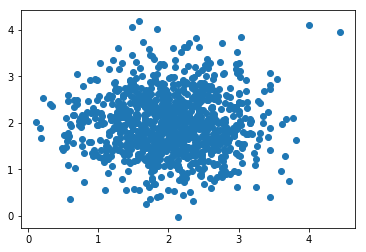

In [8]:
plt.scatter(data[:,0], data[:,1])

In [17]:
# sigma_data = 2
learning_rate = 0.00001
n_iter = 40
L = 1e6
# store_params = {}
# new_data = {}

# loop for different latent dimensions
latent_dim_options = [10]#, 7, 10, 20]
for ld in latent_dim_options:
    print(ld)
    phi1 = np.zeros((ld,2)) #* 0.3
    phi2 = np.zeros((ld,2)) #* 0.3
    theta = np.zeros((ld,2)) #* 0.3
    
#     print(phi1.shape)
    for _ in tqdm(range(n_iter)):
        for y_n in data:
            # phi1
            phi1_new = phi1 - learning_rate * grad(objective,0)(phi1, phi2, theta, latent_dim = ld, y_n = y_n)
            # phi2
            phi2_new = phi2 - learning_rate * grad(objective,1)(phi1, phi2, theta, latent_dim = ld, y_n = y_n)
            # theta1
            theta_new = theta - learning_rate * grad(objective,2)(phi1, phi2, theta, latent_dim = ld, y_n = y_n)
            # update
            phi1, phi2, theta = phi1_new, phi2_new, theta_new
        
    #store
    store_params[ld] =  [phi1, phi2, theta]
    
    ## make fake data
    new_y = np.zeros(data.shape)
    
    for k,i in enumerate(data):
        m, s = g_phi(phi1, phi2, i)
        cov = np.eye(ld)*np.exp(s)
        new_y[k] = f_theta(theta, np.random.multivariate_normal(m, cov)).flatten() \
        + np.random.multivariate_normal(mean = np.zeros(data.shape[1]) , cov = sigma_data)
    
    # store 
    new_data[ld]  = new_y

10


In [18]:
# very basic impl of running gradient descent. We should make this minibatch SGD
new_data.keys()

dict_keys([2, 10, 5])

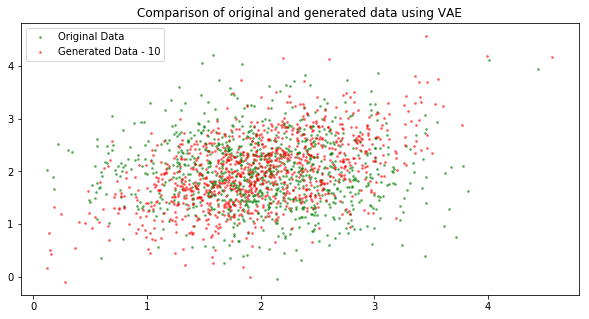

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(data[:,0],data[:,1], color = 'g', alpha = 0.5, label = 'Original Data', s = 3)
# ax.scatter(new_data[2][:,0],new_data[2][:,1], color = 'k', alpha = 0.5, label = 'Generated Data - 2', s = 3)
# ax.scatter(new_data[5][:,0],new_data[5][:,1], color = 'b', alpha = 0.5, label = 'Generated Data - 5', s = 3)
# ax.scatter(new_data[2][:,0],new_data[2][:,1], color = 'pink', alpha = 0.5, label = 'Generated Data', s = 3)
ax.scatter(new_data[10][:,0],new_data[10][:,1], color = 'r', alpha = 0.5, label = 'Generated Data - 10', s = 3)
ax.set_title('Comparison of original and generated data using VAE')
ax.legend()
plt.show()


---